[View in Colaboratory](https://colab.research.google.com/github/sibyjackgrove/Training_models_Google_Colab_TF_Dataset/blob/master/TF_Keras_model_training_GoogleDrive_Dataset_API.ipynb)

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
print(tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

1.9.0
Found GPU at: /device:GPU:0


In [2]:
#Install PyDrive to download data from Google Drive
!pip install -U -q PyDrive
!df

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Filesystem     1K-blocks    Used Available Use% Mounted on
overlay        375674948 6239724 350282328   2% /
tmpfs            6667592       0   6667592   0% /dev
tmpfs            6667592       0   6667592   0% /sys/fs/cgroup
tmpfs            6667592  254148   6413444   4% /opt/bin
/dev/sda1      382718764 7911832 374790548   3% /etc/hosts
shm                65536       0     65536   0% /dev/shm
tmpfs            6667592       0   6667592   0% /sys/firmware


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [9]:
str(folder_id)

'1JBGpZM83MB5PQfdXsj3C7Axca6erhQrl'

In [0]:
#folder_name = "./training_data_stage1"
folder_id = '1JBGpZM83MB5PQfdXsj3C7Axca6erhQrl'
READ_FILE = False
#Find ID's of all files in folder
#file_list = drive.ListFile({'q': "'1JBGpZM83MB5PQfdXsj3C7Axca6erhQrl' in parents and trashed=false"}).GetList()
file_list = drive.ListFile({'q': "'"+folder_id+"'"+" in parents and trashed=false"}).GetList()

data_list = []
file_names_ids =[]

for i,file in enumerate(file_list):
    print('File number: %s, title: %s, id: %s' % (str(i), file['title'], file['id']))
           
    
    file_names_ids.append((file['id'],file['title']))
    
#3. Read file as panda dataframe
    if READ_FILE:
        downloaded = drive.CreateFile({'id':file['id']}) # replace the id with id of file you want to access
        downloaded.GetContentFile(file['title'])
        
        data = np.load(file['title'])
        data_list.append(data)    



In [13]:
#Seperate into training and validation files
random.shuffle(file_names_ids)
file_names_ids_training = file_names_ids[0:int(len(file_names_ids)*0.8)]
file_names_ids_validation = file_names_ids[-(len(file_names_ids)-int(len(file_names_ids)*0.8)):]
file_ids_training = []
file_names_training = []
file_ids_validation = []
file_names_validation = []
for item in file_names_ids_training:
    file_ids_training.append(item[0])
    file_names_training.append(item[1])

for item in file_names_ids_validation:
    file_ids_validation.append(item[0])
    file_names_validation.append(item[1]) 
print('Number of files:',len(file_names_ids))
print('Number of training files:',len(file_names_ids_training))
print('Number of validation files:',len(file_names_ids_validation))

Number of files: 2868
Number of training files: 2294
Number of validation files: 574


In [0]:
def count_training_samples(file_names,debug=False):
    num_train_samples = 0
    for file_name in file_names:
        x_train,y_train = read_numpy_file(file_name)
        assert len(x_train) == len(y_train), 'Number of samples must be same'
        if debug:
            print('X samples:{},Y samples:{}'.format(len(x_train),len(y_train)))
        num_train_samples = num_train_samples + len(x_train)
    return num_train_samples
        
def read_numpy_file(file_name):
    
    downloaded = drive.CreateFile({'id':file_name['id']}) # replace the id with id of file you want to access
    downloaded.GetContentFile(file_name['title'])
    
    data = np.load(file_name['title'])
    #data = list(data)
    x_train = np.array([i[1] for i in data[:-10]])
    y_train = np.array([i[0] for i in data[:-10]])
    print('X shape:{},Y shape:{}'.format(x_train.shape,y_train.shape))
    return x_train,y_train

def display_training_sample(file_names):
    choice = random.choice(file_names)
    x,y = read_numpy_file(choice)
    choice = random.randrange(0, len(x))
    plt.imshow(x[choice])
    plt.title('Action:{}'.format(y[-2]))

X shape:(54, 176, 200, 3),Y shape:(54, 4)


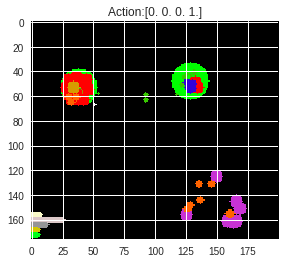

In [15]:
#file_name = file_list[0]
#x_train,y_train = read_numpy_file(file_name)
display_training_sample(file_list)
#num_train_samples = count_training_samples(file_list)
#print('Total training examples:',num_train_samples)

In [0]:
def _get_data_for_dataset(file_id,file_name):
    
    #print(file_id.decode())  #For debugging
    downloaded = drive.CreateFile({'id':file_id.decode()}) # replace the id with id of file you want to access
    downloaded.GetContentFile(file_name.decode())
    
    data = np.load(file_name.decode())
    
    #data = np.load(os.path.join(folder_name, file_name.decode()))
    #data = list(data)
    
    x_train = np.array([i[1] for i in data[:-10]]).reshape(-1, 176, 200, 3)
    y_train = np.array([i[0] for i in data[:-10]])
    return (x_train/255).astype('float32', copy=False),y_train.astype('float32', copy=False)

#Make dataset for training
dataset_train = tf.data.Dataset.from_tensor_slices((file_ids_training,file_names_training))
dataset_train = dataset_train.flat_map(lambda file_id,file_name: tf.data.Dataset.from_tensor_slices(
    tuple (tf.py_func(_get_data_for_dataset, [file_id,file_name], [tf.float32,tf.float32]))))

dataset_train= dataset_train.shuffle(buffer_size=500)
dataset_train= dataset_train.batch(128) #Make dataset, shuffle, and create batches
dataset_train= dataset_train.repeat()
dataset_train = dataset_train.prefetch(1)
dataset_train_iterator = dataset_train.make_one_shot_iterator()
get_train_batch = dataset_train_iterator.get_next()

#Make dataset for validation
dataset_valid = tf.data.Dataset.from_tensor_slices((file_ids_validation,file_names_validation))
dataset_valid = dataset_valid.flat_map(lambda file_id,file_name: tf.data.Dataset.from_tensor_slices(
    tuple (tf.py_func(_get_data_for_dataset, [file_id,file_name], [tf.float32,tf.float32]))))

dataset_valid= dataset_valid.shuffle(buffer_size=500)
dataset_valid= dataset_valid.batch(128) #Make dataset, shuffle, and create batches
dataset_valid= dataset_valid.repeat()
dataset_valid = dataset_valid.prefetch(1)
dataset_valid_iterator = dataset_valid.make_one_shot_iterator()
get_valid_batch = dataset_valid_iterator.get_next()


In [21]:
#Check if datset is giving correct output
with tf.Session() as sess:
    
    x_train,y_train = sess.run(get_train_batch)
    x_valid,y_valid = sess.run(get_valid_batch)
print(x_train.shape,y_train.shape)

(128, 176, 200, 3) (128, 4)


In [0]:
#Hyper parameters
learning_rate = 1e-4
epochs = 10

In [18]:
model = Sequential()
#model.add(InputLayer(input_shape=(176,200,3),name='Input'))
model.add(Conv2D(32,(3,3),padding='same',input_shape=(176,200,3),activation ='relu',name='Conv1'))
model.add(Conv2D(32,(3,3),activation ='relu',name='Conv2'))              #Reduces size
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),padding='same',activation ='relu',name='Conv3'))
model.add(Conv2D(64,(3,3),activation ='relu',name='Conv4'))           #Reduces size
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),padding='same',activation ='relu',name='Conv5'))
model.add(Conv2D(128,(3,3),activation ='relu',name='Conv6'))           #Reduces size
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512,activation = 'relu',name='Dense1'))
model.add(Dropout(0.2))
model.add(Dense(4,activation = 'softmax',name='Output'))

optimizer = tf.keras.optimizers.Adam(lr=learning_rate,decay=1e-6)
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy',optimizer = optimizer,metrics=['accuracy'])

tensorboard = TensorBoard(log_dir='logs/stage1')
#checkpointer = ModelCheckpoint(filepath='./keras_models/model.{epoch:02d}-{loss:.3f}-{acc:.2f}-{val_acc:.2f}.hdf5',monitor='acc',period=1)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 176, 200, 32)      896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 174, 198, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 87, 99, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 87, 99, 32)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 87, 99, 64)        18496     
_________________________________________________________________
Conv4 (Conv2D)               (None, 85, 97, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 42, 48, 64)        0         
__________

In [23]:
#Hyper parameters
epochs = 2
#model.fit(dataset, epochs=epochs, steps_per_epoch=1000,verbose=1, callbacks=[tensorboard])
model.fit(dataset_train, epochs=epochs, steps_per_epoch=10,validation_data=dataset_valid,validation_steps =10,verbose=1, callbacks=[tensorboard])#,checkpointer


Epoch 1/2
10/10 [==============================] - 46s 5s/step - loss: 1.3869 - acc: 0.2492 - val_loss: 1.3861 - val_acc: 0.2633
Epoch 2/2
10/10 [==============================] - 39s 4s/step - loss: 1.3867 - acc: 0.2609 - val_loss: 1.3855 - val_acc: 0.2734


In [25]:
#Save model
model_name = "BasicCNN-{}-epochs-{}-LR-STAGE1.h5".format(epochs, learning_rate)
model.save(model_name)
print('Model saved')
# Upload file to folder
keras_models_folder_id = '1PR8iS-ZbYX60nguD4behZaNoYCzXDjl0' #put folder id here 
f = drive.CreateFile({"parents": [{"kind": "drive#fileLink", "id": keras_models_folder_id}]})
f.SetContentFile(model_name)
f.Upload()
print('Model uploaded')


Model saved
Model uploaded
